In [33]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input,LSTM,Dense,Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
import pickle

In [34]:
df = pd.read_csv('/content/drive/MyDrive/Machine Translation/ready_dataset.csv')
df = df.iloc[:,1:]
df

,English,Spanish
0,go on,Continúa.
1,go on,Continúe.
2,hello,Hola.
3,oh no,"¡Oh, no!"
4,relax,Tomátelo con soda.
...,...,...
9995,thats house,Esa es nuestra casa.
9996,thats hotel,Ese es el hotel.
9997,thats offer,He ahí la oferta.
9998,thats trouble,Eso es problemático.


In [35]:
batch_size=64
epochs=40
LATENT_DIM=256
num_samples=10000
MAX_NUM_WORDS=20000
EMBEDDING_DIM=100

In [36]:
input_texts=[]
target_texts=[]
target_input_texts=[]
for x in df['English']:
  input_texts.append(x)
for x in df['Spanish']:
  target_texts.append(x+' <eos>')
  target_input_texts.append('<sos> '+x)

In [37]:
tokenizer=Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(input_texts)
input_sequences=tokenizer.texts_to_sequences(input_texts)

In [38]:
input_sequences[0]

[4, 56]

In [39]:
input_texts[0]

'go on'

In [40]:
#get the word to index mapping for input language
word2idx_input=tokenizer.word_index
print('found %s number of unique words'% len(word2idx_input))

found 2009 number of unique words


In [41]:
file_to_write = open('/content/drive/MyDrive/Machine Translation/word2idx_input.pickle', "wb")
pickle.dump(word2idx_input, file_to_write)

In [42]:
filename = open(r'/content/drive/MyDrive/Machine Translation/word2idx_input.pickle', 'rb')
word2idx_input=pickle.load(filename)

In [43]:
#maximum input length sequence
max_len_input=max(len(s) for s in input_sequences)

In [44]:
max_len_input

4

In [45]:
#tokenize the outputs 
#dont filter the special characters
#otherwise <sos> and <eos> wont appear
tokenizer_o=Tokenizer(num_words=MAX_NUM_WORDS,filters='')
tokenizer_o.fit_on_texts(target_texts+target_input_texts)
target_sequences=tokenizer_o.texts_to_sequences(target_texts)
target_sequences_inputs=tokenizer_o.texts_to_sequences(target_input_texts)

In [46]:
target_sequences_inputs[0]

[2, 646]

In [47]:
target_sequences[0]

[646, 1]

In [48]:
target_texts[0]

'Continúa. <eos>'

In [49]:
target_input_texts[0]

'<sos> Continúa.'

In [50]:
#get the word mapping for output language 
word2idx_outputs=tokenizer_o.word_index
print('found %s unique o/p tokens:'% len(word2idx_outputs))

found 6492 unique o/p tokens:


In [51]:
file_to_write = open('/content/drive/MyDrive/Machine Translation/word2idx_output.pickle', "wb")
pickle.dump(word2idx_outputs, file_to_write)

In [52]:
num_words_output=len(word2idx_outputs)+1

In [53]:
max_len_target=max(len(s) for s in target_sequences)
max_len_target

9

In [54]:
#pad sequences
encoder_inputs=pad_sequences(input_sequences,maxlen=max_len_input,padding='post')
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])

encoder_inputs.shape: (10000, 4)
encoder_inputs[0]: [ 4 56  0  0]


In [55]:
decoder_inputs=pad_sequences(target_sequences_inputs,maxlen=max_len_target,padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)

decoder_inputs[0]: [  2 646   0   0   0   0   0   0   0]
decoder_inputs.shape: (10000, 9)


In [56]:
decoder_targets=pad_sequences(target_sequences,maxlen=max_len_target,padding='post')

In [58]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-01-12 18:48:20--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-01-12 18:48:20--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-01-12 18:48:20--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [59]:
!unzip 'glove.6B.zip'

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [60]:
import shutil
shutil.copy('/content/glove.6B.100d.txt','/content/drive/MyDrive/Machine Translation')

'/content/drive/MyDrive/Machine Translation/glove.6B.100d.txt'

In [61]:
print('Loading word vectors...')
word2vec = {}
with open(r'/content/drive/MyDrive/Machine Translation/glove.6B.100d.txt',encoding='utf-8') as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [62]:
file_to_write = open('/content/drive/MyDrive/Machine Translation/word2vec.pickle', "wb")
pickle.dump(word2vec, file_to_write)

In [63]:
# |word2vec['the']

In [64]:
#prepare embedding matrix
num_words=min(MAX_NUM_WORDS,len(word2idx_input)+1)
embedding_matrix=np.zeros((num_words,EMBEDDING_DIM))
for word,i in word2idx_input.items():
    if i<MAX_NUM_WORDS:
        embedding_vector=word2vec.get(word)
    if embedding_vector is not None:
        embedding_matrix[i]=embedding_vector
        

In [65]:
embedding_layer=Embedding(num_words,EMBEDDING_DIM,weights=[embedding_matrix],input_length=max_len_input)

In [66]:
decoder_target_one_hot=np.zeros((len(input_texts),max_len_target,num_words_output),dtype='float32')

In [67]:
decoder_target_one_hot[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [68]:
decoder_target_one_hot.shape

(10000, 9, 6493)

In [69]:
#assign values
for i,d in enumerate(decoder_targets):
    for t, word in enumerate(d):
        decoder_target_one_hot[i,t,word]=1

In [70]:
decoder_target_one_hot[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [71]:
decoder_targets[0]

array([646,   1,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [72]:
#building the model
encoder_inputs_placeholder=Input(shape=(max_len_input,))
x=embedding_layer(encoder_inputs_placeholder)
encoder=LSTM(LATENT_DIM,return_state=True)
encoder_outputs,state_h,state_c=encoder(x)

In [73]:
decoder_inputs_placeholder=Input(shape=(max_len_target,))

In [74]:
#keep only the states to pass into decoder
encoder_states=[state_h,state_c] 

In [75]:
#since the decoder is a 'to-many' model we want to have 
#return_sequences = true

decoder_lstm=LSTM(LATENT_DIM,return_sequences=True,return_state=True)

In [76]:
decoder_embedding=Embedding(num_words_output,LATENT_DIM)
decoder_inputs_x=decoder_embedding(decoder_inputs_placeholder)
decoder_outputs, _, _ = decoder_lstm(
  decoder_inputs_x,
  initial_state=encoder_states
)

In [77]:
decoder_dense=Dense(num_words_output,activation='softmax')
decoder_outputs=decoder_dense(decoder_outputs)

In [78]:
model=Model([encoder_inputs_placeholder,decoder_inputs_placeholder],decoder_outputs)

In [79]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [80]:
r=model.fit([encoder_inputs,decoder_inputs],decoder_target_one_hot,batch_size=128,epochs=10,validation_split=0.2)

Epoch 1/10
63/63 [==============================] - 12s 75ms/step - loss: 3.9324 - accuracy: 0.5648 - val_loss: 3.2222 - val_accuracy: 0.5346
Epoch 2/10
63/63 [==============================] - 3s 48ms/step - loss: 2.4931 - accuracy: 0.6473 - val_loss: 2.9635 - val_accuracy: 0.6039
Epoch 3/10
63/63 [==============================] - 3s 48ms/step - loss: 2.2616 - accuracy: 0.6898 - val_loss: 2.8448 - val_accuracy: 0.6221
Epoch 4/10
63/63 [==============================] - 3s 48ms/step - loss: 2.1369 - accuracy: 0.6948 - val_loss: 2.7608 - val_accuracy: 0.6265
Epoch 5/10
63/63 [==============================] - 3s 53ms/step - loss: 2.0434 - accuracy: 0.7006 - val_loss: 2.7082 - val_accuracy: 0.6345
Epoch 6/10
63/63 [==============================] - 3s 48ms/step - loss: 1.9619 - accuracy: 0.7099 - val_loss: 2.6723 - val_accuracy: 0.6436
Epoch 7/10
63/63 [==============================] - 3s 48ms/step - loss: 1.8914 - accuracy: 0.7173 - val_loss: 2.6398 - val_accuracy: 0.6477
Epoch 8/10
6

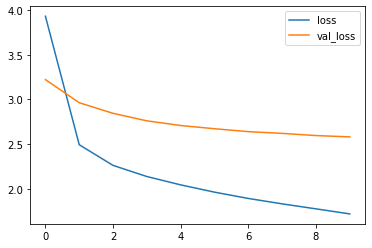

In [81]:
#plot some datab
%matplotlib inline

import matplotlib.pyplot as plt
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

In [82]:
model.save('/content/drive/MyDrive/Machine Translation/s2s.h5')


In [83]:
encoder_model=Model(encoder_inputs_placeholder,encoder_states)

In [84]:
decoder_state_input_h=Input(shape=(LATENT_DIM,))
decoder_state_input_c=Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

In [85]:
decoder_inputs_single=Input(shape=(1,)) #generating one word at a time
decoder_inputs_single_x=decoder_embedding(decoder_inputs_single)

In [86]:
#this time we want to keep the states too, to be output
#by our sampling model
decoder_outputs,h,c=decoder_lstm(decoder_inputs_single_x,initial_state=decoder_states_inputs)

In [87]:
decoder_states=[h,c]

In [88]:
#the sampling model
#inputs=y(t-1),h(t-1),c(t-1)
#outputs=y(t),h(t),c(t)
decoder_model=Model([decoder_inputs_single]+decoder_states_inputs,[decoder_outputs]+decoder_states)

In [89]:
#map index back to real words
#so wecan view the results

idx2word_en={v:k for k,v in word2idx_input.items()}
idx2word_spa={v:k for k,v in word2idx_outputs.items() }




In [90]:
file_to_write = open('/content/drive/MyDrive/Machine Translation/idx2word_en.pickle', "wb")
pickle.dump(idx2word_en, file_to_write)

In [91]:
file_to_write = open('/content/drive/MyDrive/Machine Translation/idx2word_spa.pickle', "wb")
pickle.dump(idx2word_spa, file_to_write)

In [92]:
def decode_sequence(input_seq):
    #encode the input as state vectors
    state_value=encoder_model.predict(input_seq)
    #generate empty target sequence of length 1 time step 1
    target_seq=np.zeros((1,1))
#populate the first character of target sequence with start ch.
    target_seq[0,0]=word2idx_outputs['<sos>']
    
    #if we get this we break
    eos = word2idx_outputs['<eos>']
    
    #create translation
    output_sentence=[]
    for _ in range(max_len_target):
        output_tokens,h,c=decoder_model.predict([target_seq]+state_value)
        
        #get next word
        idx=np.argmax(output_tokens[0,0,:])
        
        if eos==idx:
            break
        
        word=''
        if idx>0:
            word=idx2word_spa[idx]
            output_sentence.append(word)
            
            #update the decoder input
            #which is just the word generated
            
            target_seq[0,0]=idx
            
            #update states
            state_value=[h,c]
            
        return ' '.join(output_sentence)

In [93]:
while True:
    #do some translations
    i=np.random.choice(len(input_texts))
    
    input_seq=encoder_inputs[i:i+1]
    translation=decode_sequence(input_seq)
    print('-')
    print('Input:',input_texts[i])
    print('translation:',translation)
    
    ans=input('continue? [y/n]')
    if ans and ans.lower().startswith('n'):
        break
    

-
Input: thats gimmick
translation: sos
continue? [y/n]y
-
Input: make that
translation: bien
continue? [y/n]y
-
Input: want more
translation: ir
continue? [y/n]y
-
Input: yours
translation: sos
continue? [y/n]y
-
Input: let cat in
translation: ir
continue? [y/n]y
-
Input: go meet tom
translation: ¿qué
continue? [y/n]y
-
Input: im still alive
translation: sos
continue? [y/n]n


In [94]:
i=np.random.choice(len(input_texts))
input_seq=encoder_inputs[i:i+1]
translation=decode_sequence(input_seq)
translation

'bien'

In [95]:
tokenizer.fit_on_texts(input_texts)
input_sequences=tokenizer.texts_to_sequences(input_texts)

In [114]:
sentence = "Gold"
tokenizer.fit_on_texts([sentence])


In [115]:
input_sequences=tokenizer.texts_to_sequences([sentence])

In [116]:
input_sequences

[[2010]]

In [117]:
encoder_inputs=pad_sequences(input_sequences,maxlen=max_len_input,padding='post')

In [118]:
translation=decode_sequence(encoder_inputs)

In [119]:
translation

'dinero.'